# **DEPENDENCIES**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# **DATASET**
Description: MNIST normalized histogram of pixel values

In [24]:
(Xtr, Ytr), (Xts, Yts) = tf.keras.datasets.mnist.load_data()
# Using only Xts for SVD
Xts = Xts.reshape(Xts.shape[0], -1)
bins = np.arange(-0.5, 255.5, 1)
# Xtr = np.apply_along_axis(lambda x: np.histogram(x, bins=bins)[0], 1, Xtr)
Xts = np.apply_along_axis(lambda x: np.histogram(x, bins=bins)[0], 1, Xts)
# Xtr = Xtr / np.linalg.norm(Xtr, axis=1, keepdims=True)
Xts = Xts / np.linalg.norm(Xts, axis=1, keepdims=True)

# **PROBLEM**
Implement SVD from scratch using eigen decomposition on xtr.T @xtr. Use the top 'k' singular vectors to reconstruct the data matrix Xtr_hat. Plot the reconstruction error xtr - Xtr_hat||_F as a function of 'k' for k = 1, 2, ..


In [5]:
class SVD:
    """
    Reference [1] for the formulation
    """

    def _init_(self):
        self.s = None
        self.S = None
        self.U = None
        self.VT = None

    @staticmethod
    def _power_iteration_eigs(X, num_iter):
        # Since power iteration is slow, we'll calculate U or V, whichever is
        # smaller. This will greatly speed up the process as the extra eigen-
        # values in the bigger covariance matrix are redundant (0). Since we
        # also don't need the extra eigen-vectors (corr. to 0 eigen-values),
        # we set them to 0 as well, in the SVD formulation:
        # SVD:  X_np = U_nn @ S_np @ VT_pp
        # The 0 vectors will align with the 0 singular values and will not
        # affect the reconstruction of X_np.

        n, p = X.shape
        max_rank_X = min(n, p)

        # Selecting the covariance matrix based on the size of X
        if n < p:
            cov_mat = X @ X.T / (X.shape[0] - 1)
            # Since eigen-vectors of X @ X^T make up U
            flag = "U"
        if n >= p:
            cov_mat = X.T @ X / (X.shape[0] - 1)
            # Since eigen-vectors of X^T @ X make up V
            flag = "V"

        eig_vals = np.zeros(cov_mat.shape[0])
        eig_vecs = np.zeros((cov_mat.shape[0], cov_mat.shape[0]))

        # Power iteration
        for i in range(max_rank_X):
            b_k = np.random.rand(max_rank_X)
            for _ in range(num_iter):
                b_k1 = cov_mat @ b_k
                b_k1_norm = np.linalg.norm(b_k1)
                b_k = b_k1 / b_k1_norm
            # Rayleigh quotient
            eig_val = b_k.T @ cov_mat @ b_k
            eig_vals[i] = eig_val
            eig_vecs[:, i] = b_k
            cov_mat = cov_mat - b_k1_norm * np.outer(b_k, b_k)

        idx = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx]
        return eig_vals, eig_vecs, flag

    @staticmethod
    def frobenius_distance(X, X_hat):
        return np.linalg.norm(X - X_hat, ord="fro")

    def fit(self, X, pie_num_iter=100):
        # Assuming X is centered
        eig_vals, eig_vecs, flag = self._power_iteration_eigs(X, pie_num_iter)
        self.s = np.sqrt(eig_vals)
        self.S = np.zeros((X.shape[0], X.shape[1]))
        self.S[: eig_vals.shape[0], : eig_vals.shape[0]] = np.diag(self.s)
        if flag == "U":
            self.U = eig_vecs
            self.VT = np.zeros((X.shape[1], X.shape[1]))
            # Formula: VT = S^-1 @ U^T @ X
            self.VT[: eig_vals.shape[0], :] = np.diag(1 / self.s) @ self.U.T @ X

        if flag == "V":
            self.VT = eig_vecs.T
            self.U = np.zeros((X.shape[0], X.shape[0]))
            # Formula: U = X @ VT @ S^-1
            self.U[:, : eig_vals.shape[0]] = X @ self.VT.T @ np.diag(1 / self.s)

        # Note: U and VT need not be unique, singular values however are.

    def approx_data(self, k):
        # Computes a reduced rank approximation of the data matrix X
        # Note: X.shape = X_hat.shape
        X_hat = self.U[:, :k] @ self.S[:k, :k] @ self.VT[:k, :]
        return X_hat

# **TESTING**
1. Plot the reconstruction error xtr - Xtr_hat||_F as a function of 'k' for k = 1, 2, .., 21.

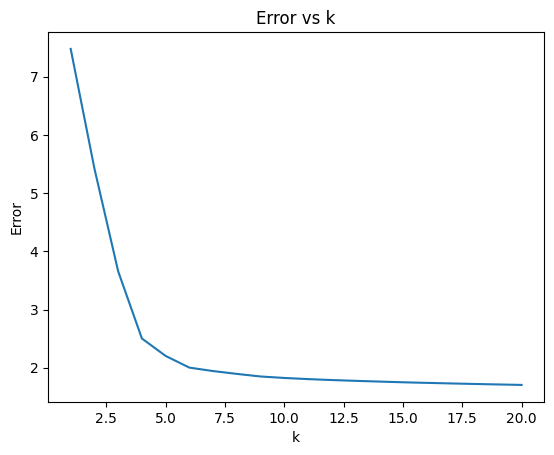

In [25]:
svd = SVD()
svd.fit(Xts)

error = []

for k in range(1, 21):
    X1_hat = svd.approx_data(k) 
    error.append(svd.frobenius_distance(Xts, X1_hat))

plt.plot(range(1, 21), error)
plt.xlabel("k")
plt.ylabel("Error")
plt.title("Error vs k")
plt.show()

# **INFERENCES**
1. As we increase the number of singular vectors, the reconstruction error decreases.
2. The dimension of the data is same i.e (10000, 255) but taking only top 'k' singular vectors, we reduce the rank of the data.

# **REFERENCES**
1. MIT - SVD  
   [Singular Value Decomposition (SVD) tutorialBE.400 / 7.548](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)

2. Redundant eigenvalues.  
   [Unequal numbers of eigenvalues and eigenvectors in SVD?](https://math.stackexchange.com/questions/1248131/unequal-numbers-of-eigenvalues-and-eigenvectors-in-svd?rq=1)

3. Eigenvectors and eigenvalues from $X^{T}X$ to $XX^{T}$ (Done to avoid redundant computation).  
   [Mathematics Stack Exchange](https://math.stackexchange.com/questions/1247983/eigenvectors-and-eigenvalues-from-xtx-to-xxt)

4. Wiki - Power Iteration.  
   [Power Iteration](https://en.wikipedia.org/wiki/Power_iteration)
